In [5]:
""" Slighly annoying: by default the SageMaker Python import directory does not include our git directory """
#!pip -q install cdxbasics "tensorflow>=2.11" "tensorflow_probability==0.19"
import os
p = os.getcwd()
dhn = "/deephedging/"
i = p.find(dhn)
my_path = None
if i!=-1:
    my_path = p[:i]
    import sys
    sys.path.append(my_path)
    print("SageMaker: added python path %s" % my_path)
else:
    print(sys.path)

SageMaker: added python path /Users/lisafaloughi/Desktop/DeepHedging


Deep Hedging AI says hello ... Tensorflow version 2.13.0 running on 1 CPUs and 0 GPUs


## Deep Hedging in a Black \& Scholes World

Initializing training at 2025-04-06 17:28:24: gym with 944 trainable weights compiled. Took 2s
Agent is using 942 weights: 941 for the main agent per step, 1 for initial delta.
 Features available per time step:     action, cost, delta, ivol, lbnd_a, pnl, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used per time step:          delta, price and time_left
 Features available for initial delta: cost, ivol, lbnd_a, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used by initial delta:       -
Monetary utility cvar@1 is using 1 weight
 Features available: cost, ivol, lbnd_a, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used:      -
Caching enabled @ '/Users/lisafaloughi/Desktop/DeepHedging/deephedging/notebooks/.deephedging_cache/61cc845c8ef5cab94c9bfbca0585e7599c983e146cde7f3a.pck'
Cache successfully loaded. Current epoch: 800
Nothing to do: cached model loaded from /Users/lisafaloughi/Desktop/DeepHedging/deephedging/notebooks/.deephedging_cache/6

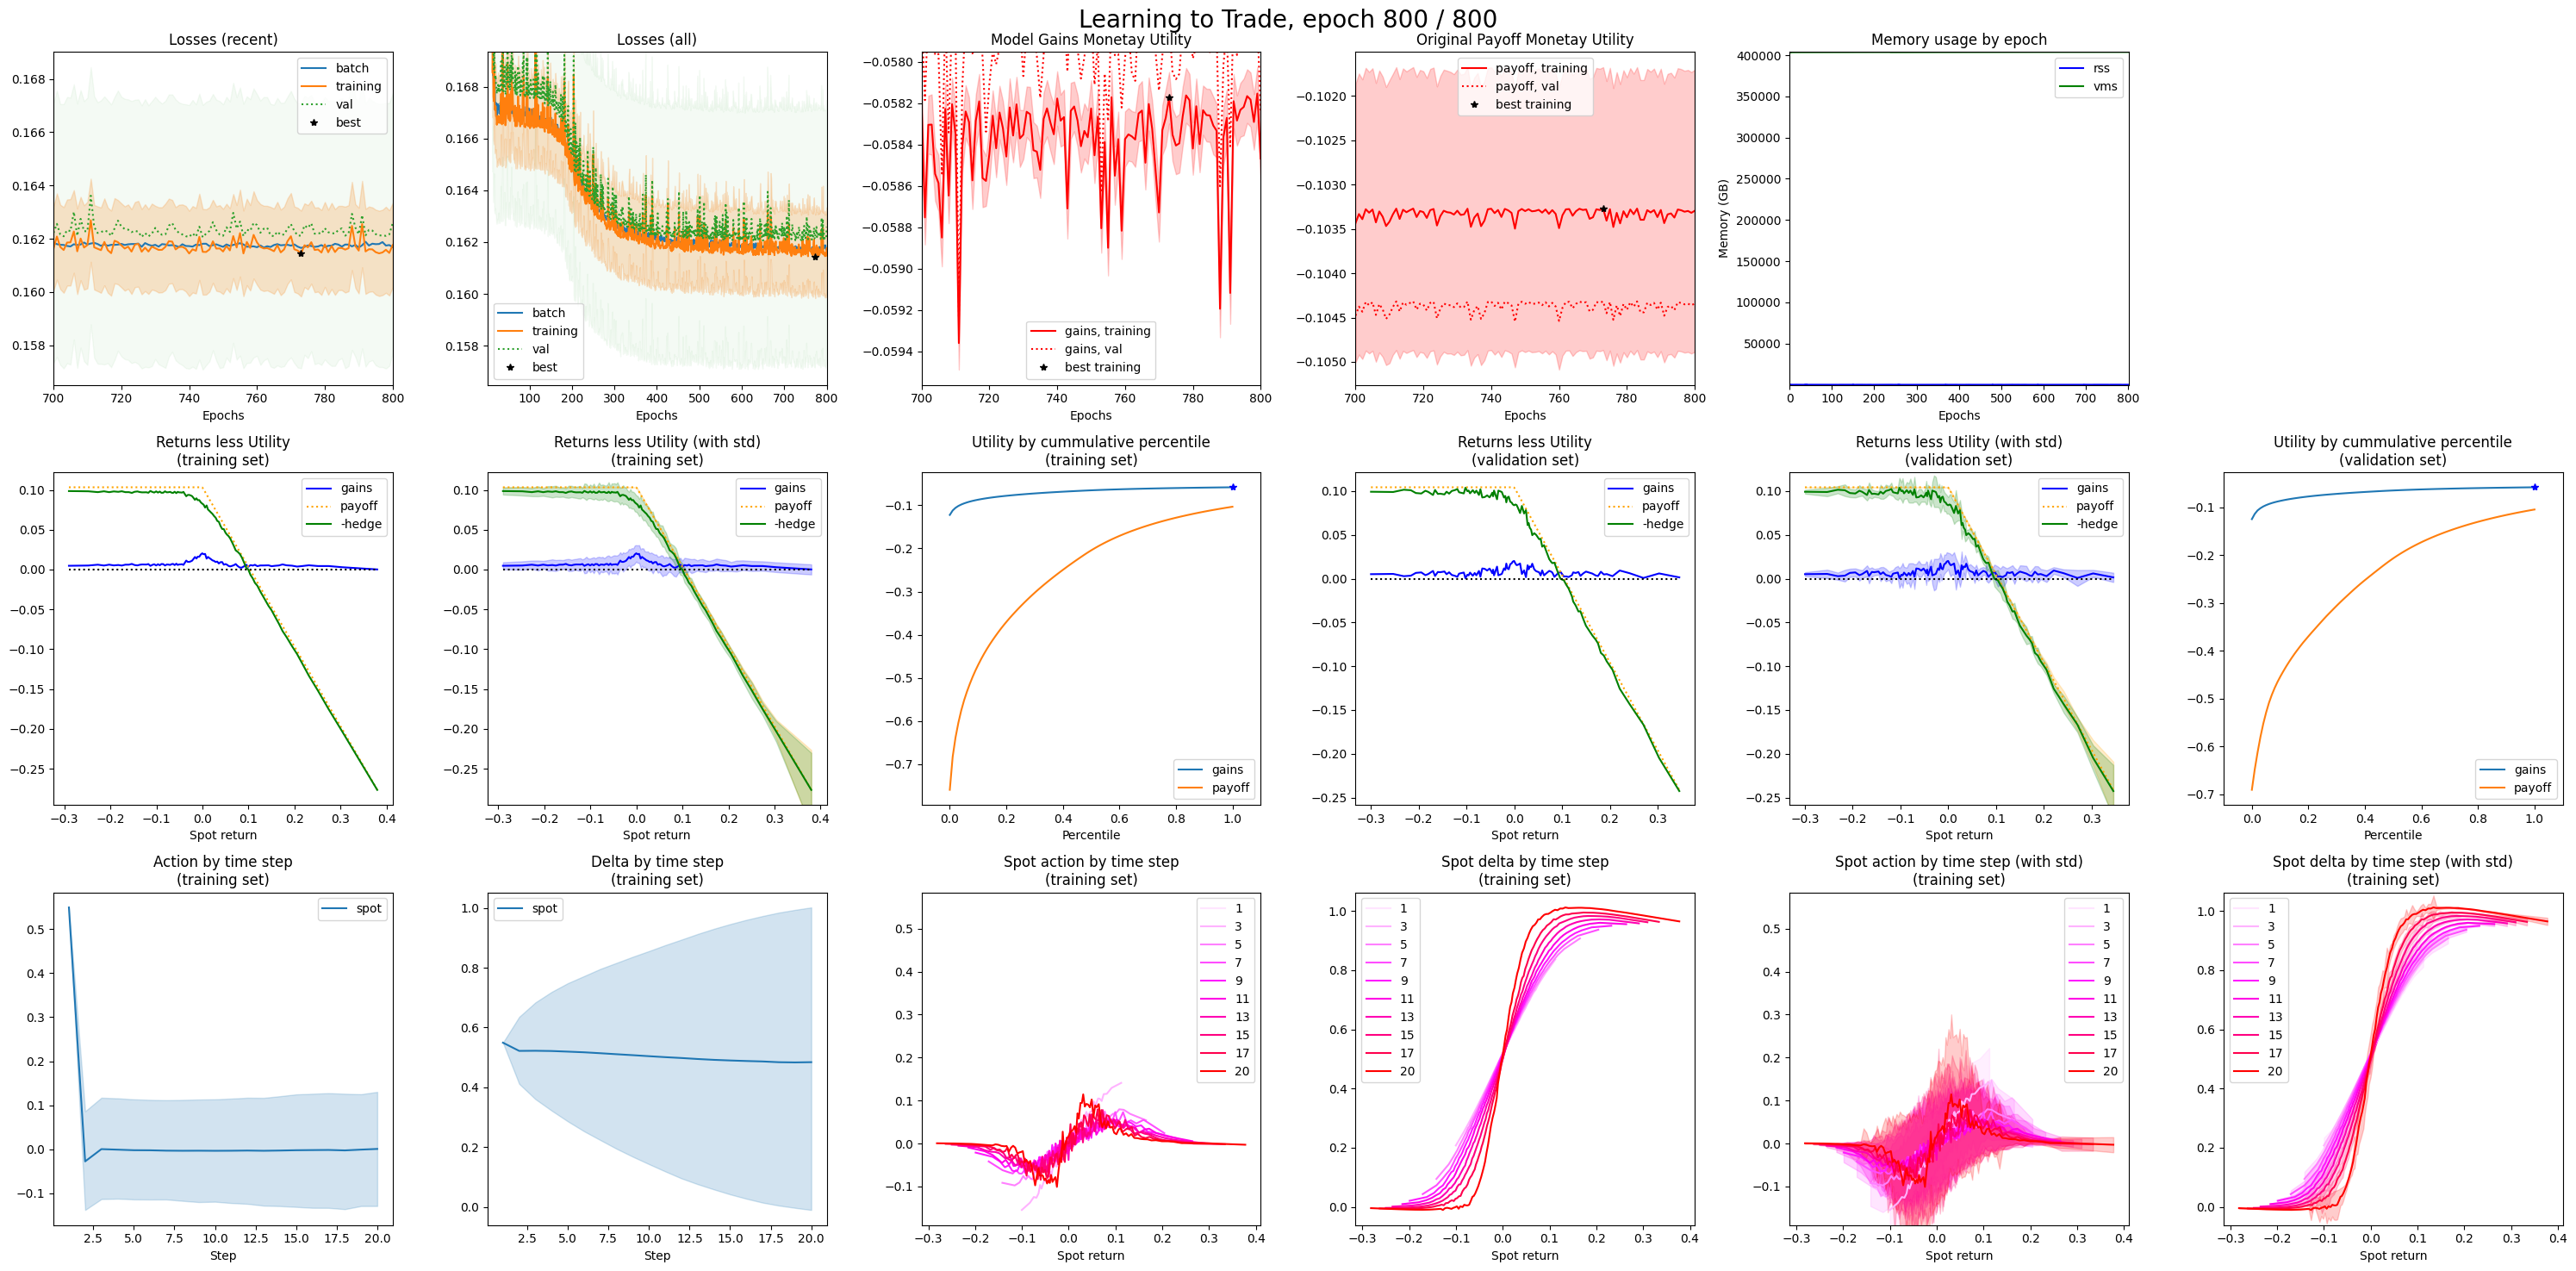

Training 800/800 epochs; 944 weights; 10000 samples; 1000 validation samples batch size 32 | initial loss 0.593179 (0.00907803), training 0.161763 (0.00157974), best 0.161444 (0.00907803), batch 0.161688, val 0.162583 (0.00488341); best epoch 773, last cached 800 | memory used: rss 149.812M, vms 403848M | time elapsed 46:06; time per epoch 3s; estimated time remaining 0s | current time: 2025-04-06 17:28:27                        
 Status: Cached model already sufficiently trained.
 Weights set to best epoch: 773
 State of training until epoch 800 cached into /Users/lisafaloughi/Desktop/DeepHedging/deephedging/notebooks/.deephedging_cache/61cc845c8ef5cab94c9bfbca0585e7599c983e146cde7f3a.pck
 Time: 2025-04-06 17:28:28
Training terminated. Total time taken 4s
Keys of the dictionary returned by the gym:  odict_keys(['loss', 'utility', 'utility0', 'gains', 'payoff', 'pnl', 'cost', 'actions'])
Config usage report
config.gym.agent.init_delta.network['activation'] = relu # Network activation f

In [2]:
print("Deep Hedging AI says hello ... ", end='')
from cdxbasics.config import Config
from deephedging.trainer import train
from deephedging.gym import VanillaDeepHedgingGym
from deephedging.world import SimpleWorld_Spot_ATM

from IPython.display import display, Markdown

# see print of the config below for numerous options
config = Config()
# world
config.world.samples = 10000
config.world.steps = 20
config.world.black_scholes = True
# gym
config.gym.objective.utility = "cvar"
config.gym.objective.lmbda = 1.
config.gym.agent.network.depth = 3
config.gym.agent.network.activation = "softplus"
# trainer
config.trainer.train.optimizer.name = "adam"
#config.trainer.train.optimizer.learning_rate = 0.001
#config.trainer.train.optimizer.clipvalue = 1.
#config.trainer.train.optimizer.global_clipnorm = 1.
config.trainer.train.batch_size = None
config.trainer.train.epochs = 800
config.trainer.caching.mode = "on"
config.trainer.visual.epoch_refresh = 5
config.trainer.visual.confidence_pcnt_lo = 0.25
config.trainer.visual.confidence_pcnt_hi = 0.75

display(Markdown("## Deep Hedging in a Black \& Scholes World"))

# create world
world  = SimpleWorld_Spot_ATM( config.world )
val_world  = world.clone(samples=world.nSamples//10)

# create training environment
gym = VanillaDeepHedgingGym( config.gym )

# create training environment
train( gym=gym, world=world, val_world=val_world, config=config.trainer )
r = gym(world.tf_data)
print("Keys of the dictionary returned by the gym: ", r.keys())

print("=========================================")
print("Config usage report")
print("=========================================")
print( config.usage_report() )
config.done()


In [9]:
import numpy as np
import tensorflow as tf
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pickle

# Step 1: Run the model
result = gym(world.tf_data)

# Step 2: Extract components
price     = world.data.features.per_step['price']       # shape: (10000, 20)
time_left = world.data.features.per_step['time_left']   # shape: (10000, 20)
delta     = tf.cumsum(result['actions'], axis=1).numpy()[:, :, 0]  # shape: (10000, 20)       # shape: (10000, 20)

In [10]:
print("time_left shape:", delta.shape)
print("time_left min:", np.min(delta))
print("time_left max:", np.max(delta))

time_left shape: (10000, 20)
time_left min: -0.40118027
time_left max: 1.4096808


In [11]:
# Step 3: Flatten and combine in correct order
X = np.stack([price, delta, time_left], axis=2)  # shape: (10000, 20, 3)

# Ensure ordering matches agent.features (sorted): delta, price, time_left
feature_names = ['price', 'delta', 'time_left']
sorted_names = sorted(feature_names)  # --> ['delta', 'price', 'time_left']

# Create index mapping
name_to_array = {
    'price': price,
    'delta': delta,
    'time_left': time_left
}
X_sorted = np.stack([name_to_array[k] for k in sorted_names], axis=2).reshape(-1, 3)

In [18]:
from sklearn.preprocessing import StandardScaler

# --- Step 2: Standardize features (zero mean, unit variance) ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_sorted)  # shape: (200000, 3)

In [20]:
from sklearn.cluster import KMeans
import pickle

# Run KMeans
n_prototypes = 1000
kmeans = KMeans(n_clusters=n_prototypes, random_state=0, n_init='auto')
kmeans.fit(X_scaled)

KMeans(n_clusters=1000, random_state=0)

In [22]:
import numpy as np

prototypes = kmeans.cluster_centers_

# Set print options for cleaner display
np.set_printoptions(precision=3, suppress=True)

# Compute min and max for each column (feature)
X_min = X_scaled.min(axis=0)
X_max = X_scaled.max(axis=0)

proto_min = prototypes.min(axis=0)
proto_max = prototypes.max(axis=0)

# Print results
print("Feature order: [delta, price, time_left]\n")

print("X_sorted:")
print("  Min:", X_min)
print("  Max:", X_max)

print("\nPrototypes:")
print("  Min:", proto_min)
print("  Max:", proto_max)

Feature order: [delta, price, time_left]

X_sorted:
  Min: [-3.101 -4.486 -1.648]
  Max: [3.099 6.467 1.648]

Prototypes:
  Min: [-2.863 -4.467 -1.648]
  Max: [3.099 6.156 1.647]


In [23]:
prototypes = kmeans.cluster_centers_

# --- Step 4: Save cluster centers and the fitted scaler ---
with open("prototypes.pkl", "wb") as f:
    pickle.dump({
        "prototypes": kmeans.cluster_centers_,  # standardized space!
        "scaler": scaler                        # full StandardScaler object
    }, f)

print("✅ Prototypes and scaler saved to prototypes.pkl")

✅ Prototypes and scaler saved to prototypes.pkl


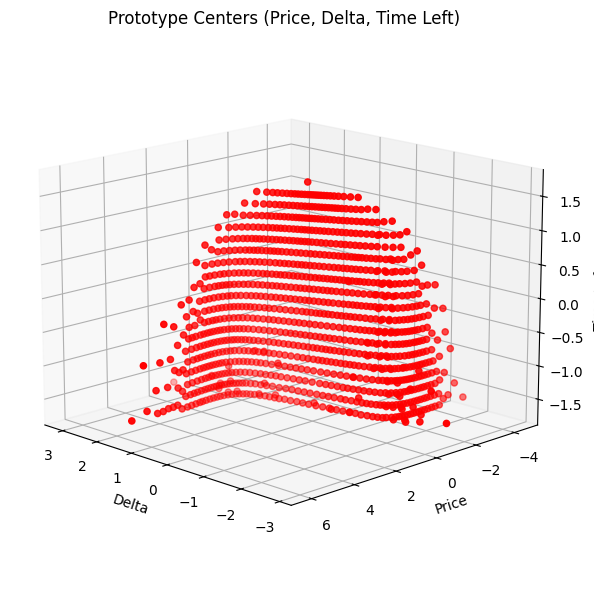

In [24]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Extract individual axes
x = prototypes[:, 0]  # Delta
y = prototypes[:, 1]  # Price
z = prototypes[:, 2]  # Time Left

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

# Plot
ax.scatter(x, y, z, c='red', s=20)

# Set labels
ax.set_xlabel("Delta")
ax.set_ylabel("Price")
ax.set_zlabel("Time Left")

# Optional: Adjust the viewing angle
ax.view_init(elev=15, azim=135)

ax.set_title("Prototype Centers (Price, Delta, Time Left)")
plt.tight_layout()
plt.show()

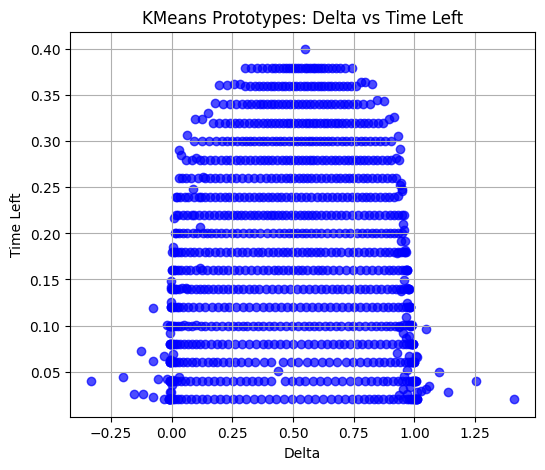

In [30]:
import matplotlib.pyplot as plt

# Select delta and time_left dimensions from your prototypes
# Assuming columns: [price, delta, time_left]
delta = prototypes[:, 0]
time_left = prototypes[:, 2]

# Plotting
plt.figure(figsize=(6, 5))
plt.scatter(delta, time_left, c='blue', alpha=0.7)
plt.title("KMeans Prototypes: Delta vs Time Left")
plt.xlabel("Delta")
plt.ylabel("Time Left")
plt.grid(True)
plt.show()

## Stochastic Prototypes

Deep Hedging AI says hello  ... 

## Deep Hedging in a simple Stochastic Volatility World

INFO:tensorflow:Enabled check-numerics callback in thread MainThread


INFO:tensorflow:Enabled check-numerics callback in thread MainThread


Initializing training at 2025-04-08 16:30:04: gym with 1006 trainable weights compiled. Took 3s
Agent is using 1004 weights: 1002 for the main agent per step, 2 for initial delta.
 Features available per time step:     action, call_delta, call_price, call_vega, cost, cost_v, delta, ivol, lbnd_a, pnl, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used per time step:          delta, price and time_left
 Features available for initial delta: call_delta, call_price, call_vega, cost, cost_v, ivol, lbnd_a, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used by initial delta:       -
Monetary utility cvar@1 is using 1 weight
 Features available: call_delta, call_price, call_vega, cost, cost_v, ivol, lbnd_a, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used:      -
Caching enabled @ '/Users/lisafaloughi/Desktop/DeepHedging/deephedging/notebooks/.deephedging_cache/0289de81ceae5149b374906e1eef963ea942d6263b8cf383.pck'
Cache successfully loaded. Current e

INFO:tensorflow:Disabled check-numerics callback in thread MainThread


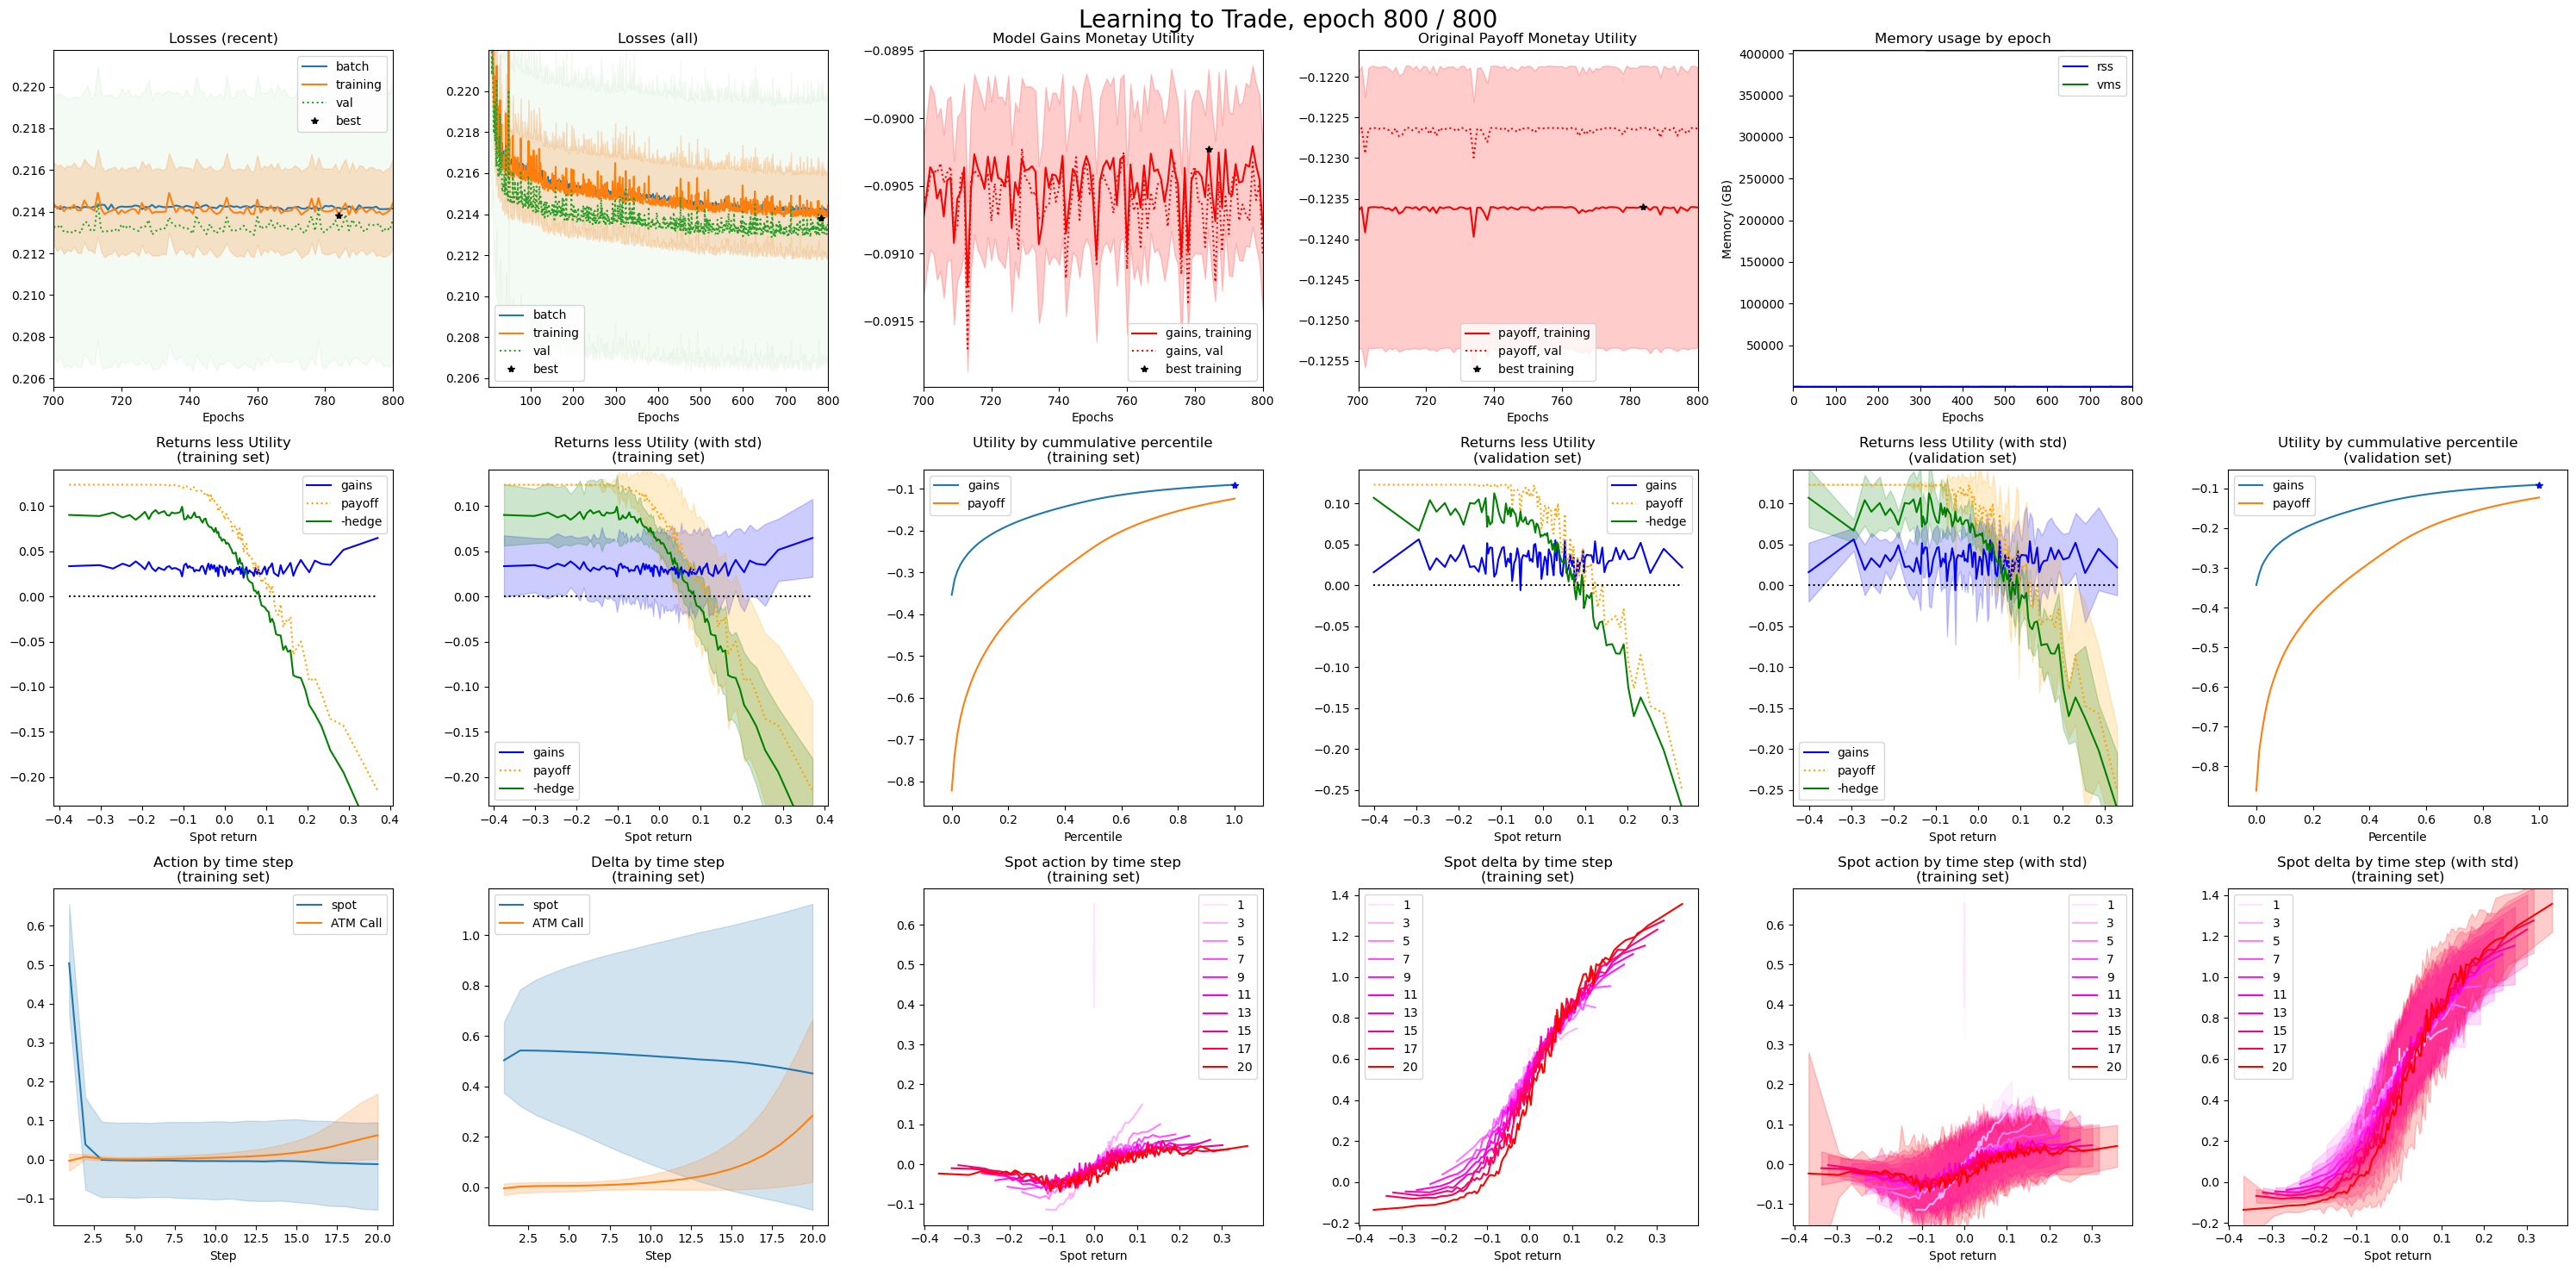

Training 800/800 epochs; 1006 weights; 10000 samples; 1000 validation samples batch size 32 | initial loss 0.7133 (0.0101046), training 0.21442 (0.00212935), best 0.213832 (0.0101046), batch 0.214154, val 0.213644 (0.00676745); best epoch 784, last cached 800 | memory used: rss 172.703M, vms 403947M | time elapsed 2:37:48; time per epoch 11s; estimated time remaining 0s | current time: 2025-04-08 16:30:08                        
 Status: Cached model already sufficiently trained.
 Weights set to best epoch: 784
 State of training until epoch 800 cached into /Users/lisafaloughi/Desktop/DeepHedging/deephedging/notebooks/.deephedging_cache/0289de81ceae5149b374906e1eef963ea942d6263b8cf383.pck
 Time: 2025-04-08 16:30:09
Training terminated. Total time taken 4s
Keys of the dictionary returned by the gym:  odict_keys(['loss', 'utility', 'utility0', 'gains', 'payoff', 'pnl', 'cost', 'actions'])
Config usage report
config.gym.agent.init_delta.network['activation'] = relu # Network activation fu

In [38]:
print("Deep Hedging AI says hello  ... ", end='')
from cdxbasics.config import Config
from deephedging.trainer import train
from deephedging.gym import VanillaDeepHedgingGym
from deephedging.world import SimpleWorld_Spot_ATM
import tensorflow as tf

from IPython.display import display, Markdown

# see print of the config below for numerous options
config = Config()
# world
config.world.samples = 10000
config.world.steps = 20
config.world.black_scholes = False
# gym
config.gym.objective.utility = "cvar"
config.gym.objective.lmbda = 1.
config.gym.agent.network.depth = 3
config.gym.agent.network.activation = "softplus"
# trainer
config.trainer.train.optimizer.name = "adam"
config.trainer.train.optimizer.learning_rate = 0.001
config.trainer.train.optimizer.clipvalue = 1.
config.trainer.train.optimizer.global_clipnorm = 1.
config.trainer.train.batch_size = None
config.trainer.train.epochs = 800
config.trainer.caching.mode = "on"
config.trainer.train.run_eagerly = None
config.trainer.visual.epoch_refresh = 5
config.trainer.visual.confidence_pcnt_lo = 0.25
config.trainer.visual.confidence_pcnt_hi = 0.75

display(Markdown("## Deep Hedging in a simple Stochastic Volatility World"))

# create world
world  = SimpleWorld_Spot_ATM( config.world )
val_world  = world.clone(samples=world.nSamples//10)

# create training environment
tf.debugging.enable_check_numerics()
gym = VanillaDeepHedgingGym( config.gym )

# create training environment
train( gym=gym, world=world, val_world=val_world, config=config.trainer )
r = gym(world.tf_data)
print("Keys of the dictionary returned by the gym: ", r.keys())

print("=========================================")
print("Config usage report")
print("=========================================")
print( config.usage_report() )
config.done()

In [39]:
import numpy as np
import pickle
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

# Step 1: Run the model
result = gym(world.tf_data)

# Step 2: Extract per-step components
price      = world.data.features.per_step['price']       # shape: (10000, 20, 2)
time_left  = world.data.features.per_step['time_left']   # shape: (10000, 20)
actions    = result["actions"].numpy()                            # shape: (10000, 20, 2)
delta      = np.cumsum(actions, axis=1)                           # shape: (10000, 20, 2)

In [42]:
print("time_left shape:", time_left.shape)
print("time_left min:", np.min(time_left))
print("time_left max:", np.max(time_left))

time_left shape: (10000, 20)
time_left min: 0.02
time_left max: 0.39999998


In [43]:
# Flatten and stack feature vectors into shape (10000 * 20, 5)
# Features: [price_1, delta_1, price_2, delta_2, time_left]
price_1 = price[:, :, 0].reshape(-1)
delta_1 = delta[:, :, 0].reshape(-1)
price_2 = price[:, :, 1].reshape(-1)
delta_2 = delta[:, :, 1].reshape(-1)
time    = time_left.reshape(-1)

# Final feature matrix: [samples * timesteps, 5]
X_all = np.stack([delta_1, delta_2, price_1, price_2, time], axis=1)
print("✅ X_all shape:", X_all.shape)  # Expect (200000, 5)

✅ X_all shape: (200000, 5)


In [44]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_all)

print("Feature-wise min/max after scaling:")
print("Min:", X_scaled.min(axis=0))
print("Max:", X_scaled.max(axis=0))

Feature-wise min/max after scaling:
Min: [-6.8168163 -1.5376111 -5.888356  -2.7831306 -1.647509 ]
Max: [3.42934   9.701441  5.249192  8.381535  1.6475089]


In [45]:
from sklearn.cluster import KMeans

n_prototypes = 3000
kmeans = KMeans(n_clusters=n_prototypes, random_state=0, n_init='auto')
kmeans.fit(X_scaled)

prototypes = kmeans.cluster_centers_

In [46]:
import pickle

with open("prototypes_stochastic.pkl", "wb") as f:
    pickle.dump({
        "prototypes": prototypes,
        "scaler": scaler
    }, f)

print("✅ Saved prototypes and scaler to prototypes_stochastic.pkl")

✅ Saved prototypes and scaler to prototypes_stochastic.pkl


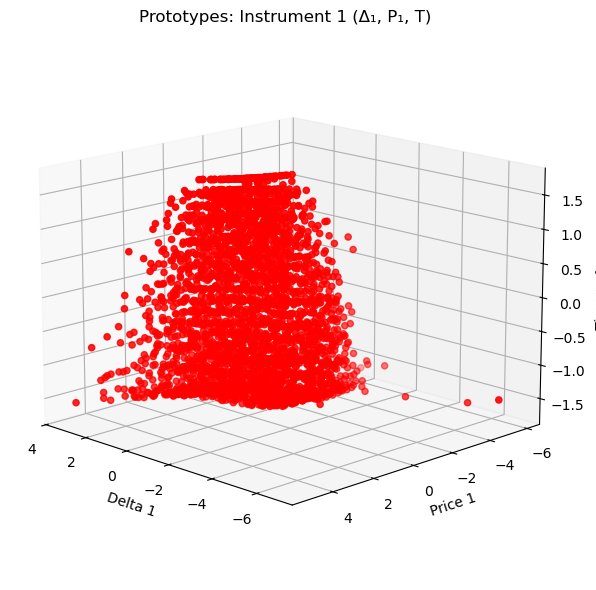

In [47]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

x = prototypes[:, 0]  # delta₁
y = prototypes[:, 2]  # price₁
z = prototypes[:, 4]  # time_left

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='red', s=20)

ax.set_xlabel("Delta 1")
ax.set_ylabel("Price 1")
ax.set_zlabel("Time Left")
ax.view_init(elev=15, azim=135)
ax.set_title("Prototypes: Instrument 1 (Δ₁, P₁, T)")
plt.tight_layout()
plt.show()

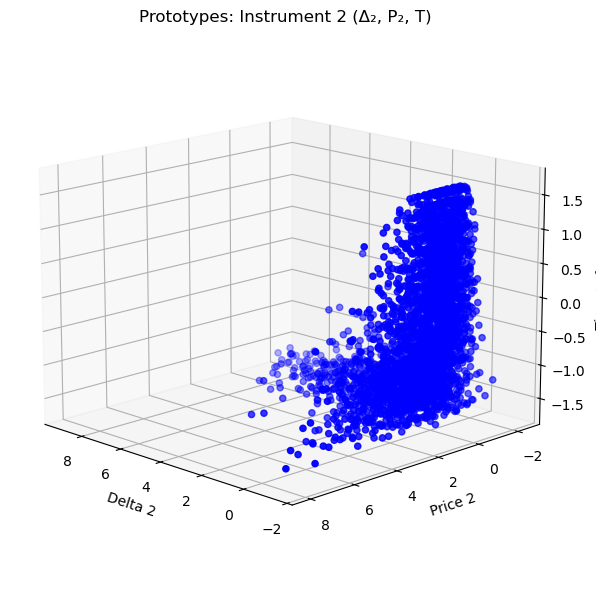

In [48]:
x = prototypes[:, 1]  # delta₂
y = prototypes[:, 3]  # price₂
z = prototypes[:, 4]  # time_left

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='blue', s=20)

ax.set_xlabel("Delta 2")
ax.set_ylabel("Price 2")
ax.set_zlabel("Time Left")
ax.view_init(elev=15, azim=135)
ax.set_title("Prototypes: Instrument 2 (Δ₂, P₂, T)")
plt.tight_layout()
plt.show()

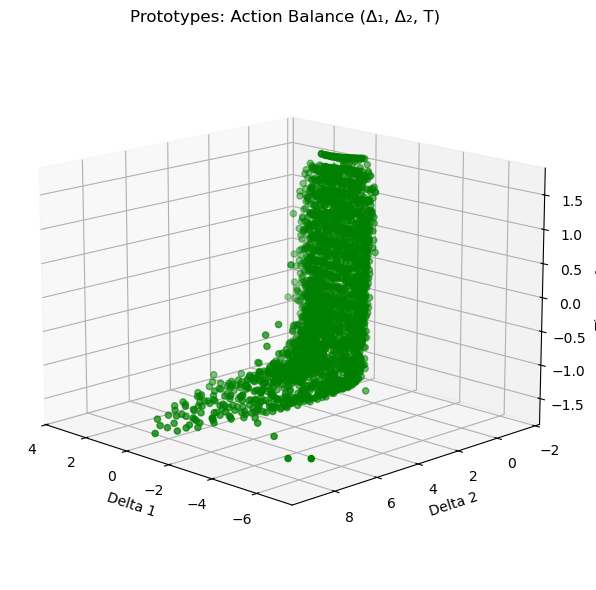

In [49]:
x = prototypes[:, 0]  # delta₁
y = prototypes[:, 1]  # delta₂
z = prototypes[:, 4]  # time_left

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='green', s=20)

ax.set_xlabel("Delta 1")
ax.set_ylabel("Delta 2")
ax.set_zlabel("Time Left")
ax.view_init(elev=15, azim=135)
ax.set_title("Prototypes: Action Balance (Δ₁, Δ₂, T)")
plt.tight_layout()
plt.show()

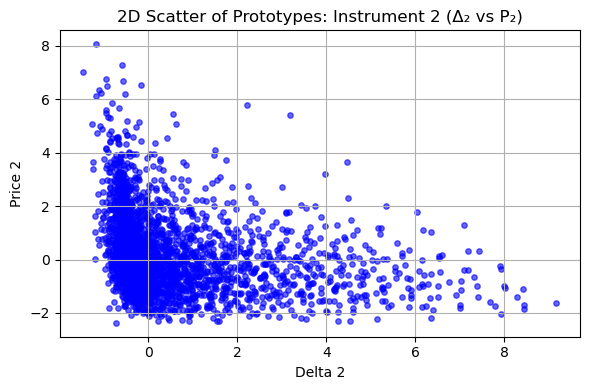

In [50]:
import matplotlib.pyplot as plt

# Extract 2D coordinates
x = prototypes[:, 1]  # delta₂
y = prototypes[:, 3]  # price₂

# Plot
plt.figure(figsize=(6, 4))
plt.scatter(x, y, c='blue', s=15, alpha=0.6)

# Labels and title
plt.xlabel("Delta 2")
plt.ylabel("Price 2")
plt.title("2D Scatter of Prototypes: Instrument 2 (Δ₂ vs P₂)")
plt.grid(True)
plt.tight_layout()
plt.show()